In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import norm
from scipy import stats

The main idea is to find a Monte Carlo estimator with a smaller variance than the standard estimator $$ \frac{1}{N} \sum_{n=1}^{N} \phi(X_n) $$. There are two main methods: 

- antithec variables 
- control variables

## Antithetic variables

In [2]:
def get_rand_number(min_value, max_value):
    """
    This function gets a random number from a uniform distribution between
    the two input values [min_value, max_value] inclusively
    Args:
    - min_value (float)
    - max_value (float)
    Return:
    - Random number between this range (float)
    """
    range = max_value - min_value
    choice = random.uniform(0,1)
    return min_value + range*choice

In [3]:
def get_estimator_anti(fct, N):
    """
    This function returns the antithetic estimator which is unbiased and consistant.
    Args:
    - fct: the function we want to estimate
    - N (int)
    Return:
    - Monte Carlo antithetic estimator of f(x) (float)
    """
    sum_of_samples = 0 
    for i in range(N):
        x = get_rand_number(-10, 10)
        sum_of_samples += (fct(x) + fct(-x))
    est = float((1 / (2*N)) * sum_of_samples)
    return est

In [4]:
def f(x):
    """
    Compute normal density
    """
    return 1/np.sqrt(2*np.pi) * np.exp(-1/2*x**2)

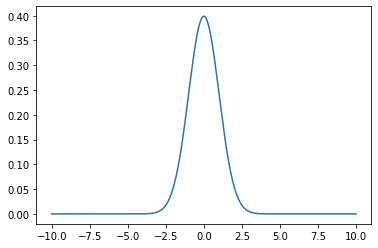

In [5]:
interval = np.linspace(-10,10,1000)
fx = f(interval)
plt.plot(interval,fx)

In [6]:
test = get_estimator_anti(f, 100_000)

In [7]:
print(test)

0.05020227925934575


In [8]:
def get_IMC_variance(fct, N):
    """
    This function returns the variance of Monte Carlo antithetic estimator.
    Args:
    - fct: the function we want to estimate
    - N (int)
    Return:
    - Variance for Monte Carlo antithetic approximation of f(x) (float)
    """    
    # get the average of squares
    sum_of_samples = 0
    for i in range(N):
        x = get_rand_number(-10, 10)
        sum_of_samples += (fct(x) + fct(-x))**2
    sum_of_sqs = float( 1 / (4*N) * sum_of_samples )
    
    # get square of average
    running_total = 0
    for i in range(N):
        x = get_rand_number(-10, 10)
        running_total = (fct(x) + fct(-x))
    sq_ave = float((running_total/ (2* N))**2)
    
    return sum_of_sqs - sq_ave

In [9]:
get_IMC_variance(f, 100_000)

0.01405183338693272

### Comparison

In [10]:
def get_estimator(fct, N):
    """
    This function returns the Monte Carlo estimator.
    Args:
    - fct: the function we want to estimate
    - N (int)
    Return:
    - Monte Carlo estimator of f(x) (float)
    """
    sum_of_samples = 0 
    for i in range(N):
        x = get_rand_number(-10, 10)
        sum_of_samples += fct(x)
    est = float((1 / N) * sum_of_samples)
    return est

In [11]:
test = get_estimator(f, 100_000)
test

0.05000935564305792

In [12]:
def get_variance(fct, N):
    """
    This function returns the variance of Monte Carlo estimator.
    Args:
    - fct: the function we want to estimate
    - N (int)
    Return:
    - Variance for Monte Carlo approximation of f(x) (float)
    """    
    # get the average of squares
    sum_of_samples = 0
    for i in range(N):
        x = get_rand_number(-10, 10)
        sum_of_samples += fct(x)**2
    sum_of_sqs = float(sum_of_samples /N)
    
    # get square of average
    running_total = 0
    for i in range(N):
        x = get_rand_number(-10, 10)
        running_total = fct(x)
    sq_ave = float((running_total/ N)**2)
    
    return sum_of_sqs - sq_ave

In [13]:
get_variance(f, 100_000)

0.014302603168496743

# Importance sampling

Importance sampling is a method for reducing the variance of a Monte Carlo simulation without increasing the number of samples. The idea is that instead of randomly sampling from the whole function we will sample from a distribution of points similarly shaped to the function.


$$
\begin{aligned}
\mathbb{E}[\varphi(X)] &=\int_{\mathcal{X}} \varphi(x) f(x) d x \\
&=\int_{\mathcal{X}} \varphi(x) \frac{f(x)}{g(x)} g(x) d x=\mathbb{E}_{g}\left[\frac{f(X)}{g(X)} \varphi(X)\right]
\end{aligned}
$$
assuming $$\operatorname{Supp}(f) \subset \operatorname{Supp}(g)$$

Any expectation w.r.t. PDF $f$ may be rewritten thusly as an expectation
w.r.t. PDF $g$ (which may be easier to simulate from):
$$
\hat{l}_{l S}=\frac{1}{N} \sum_{n=1}^{N} \frac{f\left(X_{n}\right)}{g\left(X_{n}\right)} \varphi\left(X_{n}\right)
$$

In [14]:
def g(x):
    """
    Compute Cauchy distribution density
    """
    return 1/(np.pi*(1+x**2))

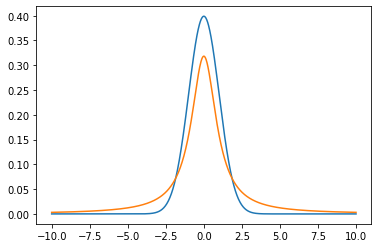

In [15]:
interval = np.linspace(-10,10,1000)
gx = g(interval)
plt.plot(interval, fx)
plt.plot(interval,gx)

Let's suppose that we want to estimate $$ P(Y > 3)$$ where $$ Y \sim N(0,1)$$. 
In this case, rather than the N(0,1) we can use the exponential density truncated at 5 and use importance sampling to estimate this probability.

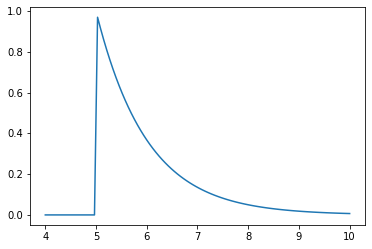

In [16]:
x = np.linspace(4, 10, 100)
plt.plot(x, stats.expon(5).pdf(x))

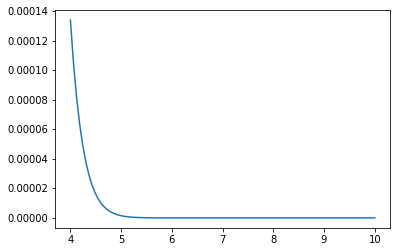

In [17]:
plt.plot(x, stats.norm().pdf(x))

In [18]:
# true expected value 
h_true = 1 - stats.norm().cdf(5)
h_true

2.866515719235352e-07

#### Using classical Monte Carlo method

In [19]:
N = 100_0000
y = stats.norm().rvs(N)
h_MC_classical = float(1/N * np.sum(y > 5))
h_MC_classical

0.0

In [20]:
# The relative error 
np.abs(h_MC_classical - h_true)/h_true

1.0

#### Using Importance Sampling

In [21]:
N = 100_000
y = stats.expon(loc=5).rvs(N)
h_IS = float(1/N * np.sum(stats.norm().pdf(y)/stats.expon(loc=5).pdf(y)))
h_IS

2.8618556876647134e-07

In [22]:
# The relative error
np.abs(h_IS - h_true)/h_true

0.0016256780101947398